# 0.0 IMPORTS

In [49]:
import pandas as pd
import inflection
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

## 0.1. Helper functions

In [66]:
# setting seaborn style
sns.set_style("darkgrid")
sns.set_palette("Accent")

# setting matplolit inline
%matplotlib inline

## 0.2 Loading dada

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
468854,225,3,2014-05-07,6172,603,1,1,0,0,d,a,10180.0,5.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

In [4]:
# make a copy from original DataFrame, so we can separate the dataset manipulation by section
df1 = df_raw.copy()

## 1.1. Rename columns
Rename columns to make easier to understand and work with them.

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# snake_case
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [7]:
# verifying the operations
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2.  Data dimensions
Verify the number of rows and columns in the dataset.

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3.  Data types
Verifying the dataset data types.

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# transforming 'date' column to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Check NaN
Verifying presence of missing values.

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We noticed that we have a lot of missing data. We can one of the following three paths:

**1) Exclude all lines that have missing data**, but we may lose important information that the ML algorithm may need and negatively impact the forecasting.

**2) Use ML techniques to fill in the missing data** and predict what value would be replace `NaN`. This method is good when we don't have business information available.

**3) Really understand the business.** Understand the business rules and fill in the missing data with relevant information.

## 1.5.  Fillout NA
We chose the method 3 (understand the business). Let's take a look at data field descriptions from Kaggle.

https://www.kaggle.com/c/rossmann-store-sales/data

### Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [12]:
# observing the maximum distance to the nearest competitor
df1['competition_distance'].max()

75860.0

In [13]:
# competition_distance
# let's assume that the distance from competitors is so long that there are no competitors
# applying for each column record: competition_distance
#     assign 200000.0 if record == NaN ; assign its current value if record != NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# let's assume that the opening date is the store date: date
# axis=1 -> apply in the row along the columns, because we have more than one column in the expression
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [14]:
# promo_interval

# creating dictionary that will help in mapping
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# fill in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

# creating the 'month_map' column as the month mapping of the 'date' column
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [15]:
df1.sample(5).T

,550280,73522,644317,450596,530918
store,256,1048,633,922,964
day_of_week,7,3,7,6,4
date,2014-02-23 00:00:00,2015-05-27 00:00:00,2013-12-01 00:00:00,2014-05-24 00:00:00,2014-03-13 00:00:00
sales,0,6094,0,7611,8319
customers,0,491,0,762,1354
open,0,1,0,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,d,d,a


In [16]:
# make a split in 'promo_interval' column and creates a list containing the values
# check if the value of 'month_map' is within that list
# creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
df1.sample(5).T

,247431,937513,664007,978474,571176
store,922,584,253,290,1082
day_of_week,6,3,3,1,3
date,2014-12-20 00:00:00,2013-03-13 00:00:00,2013-11-13 00:00:00,2013-02-04 00:00:00,2014-02-05 00:00:00
sales,11127,3000,5100,11579,8050
customers,987,301,669,1005,1048
open,1,1,1,1,1
promo,0,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,d,a,a,c


In [19]:
# verificando operações
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6.  Change types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

We notice that the following columns are `float64`:
- `competition_open_since_month`
- `competition_open_since_year`
- `promo2_since_week` 
- `promo2_since_year` 

However, they are actually `int` values as the represent months and years which are discrete values. Thus, we can do:

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
# checking the operations
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

It is through the descriptive statistics that we get a notion from the business. 

It helps detect some errors

Two big metrics: distribution and central tendency

Central tendency: summary statistics, median, mean

We need to know how the data is distributed around the median and mean.

Skew and kurtosis.

Check how vars behave. Negative values that shouldn't

In [24]:
# creating a dataset for numerical attributes
num_attributes = df1.select_dtypes(include=['int64','float64'])

# creating a dataset for categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [26]:
# checking the operation
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
365550,175,5,5047,621,1,0,1,4130.0,8,2014,0,33,2014,0
275904,311,3,5940,856,1,0,0,680.0,7,2005,0,47,2014,0


In [27]:
# checking the operation
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
178743,0,a,c,"Jan,Apr,Jul,Oct",Fev
962796,0,a,a,0,Fev


### 1.7.1 Numerical attributes

In [31]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [32]:
# checking the operations
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


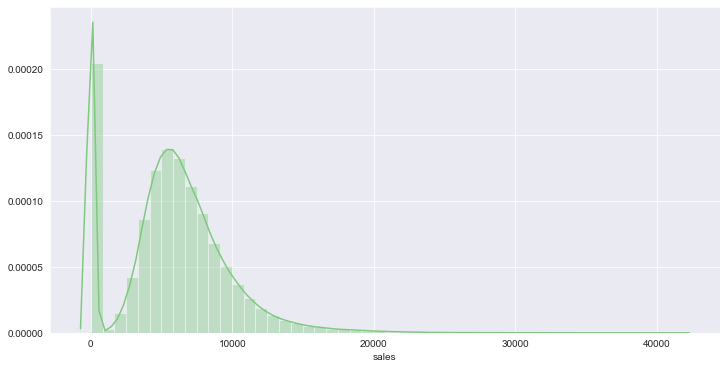

In [68]:
ax = sns.distplot(df1['sales'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

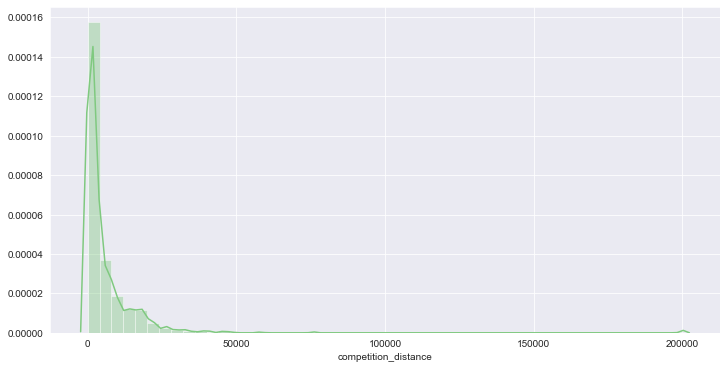

In [69]:
ax = sns.distplot(df1['competition_distance'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

### 1.7.1 Categorical attributes

In [43]:
# check how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

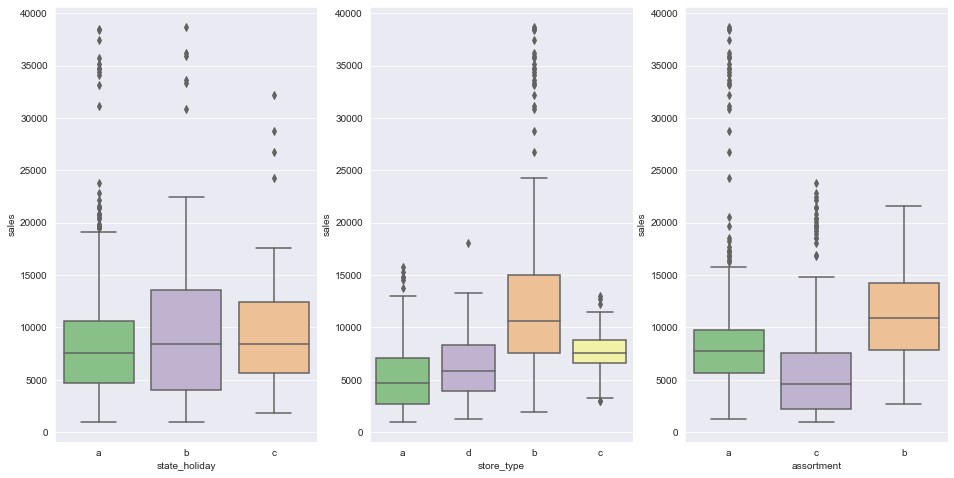

In [67]:
# filtering the data that we want to display
# as we don't want to see all the days on which the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1)

# display plot
plt.show()

## 1.1. 